In [1]:
import matplotlib.pyplot as plt
import numpy as np
from keras.layers import BatchNormalization,Dropout,Dense,Activation,Flatten,Reshape
from keras.layers.advanced_activations import LeakyReLU
from keras.models import Sequential
from keras.layers.convolutional import Conv2D,Conv2DTranspose
from keras.optimizers import Adam 
from keras.datasets import mnist

Using TensorFlow backend.


In [0]:
# parameters 
img_rows = 28
img_cols = 28
channels = 1
img_shape = (img_rows,img_cols,channels)
noise_dim = 100

In [0]:
def build_generator(noise_dim):
    model = Sequential()
    # Reshape input into 7x7x256 tensor via fully connected dense layer
    model.add(Dense(256*7*7, input_dim = noise_dim))
    model.add(Reshape((7,7,256)))
    
    # converting using ConvTranspose 7x7x256 to 14x14x128 
    model.add(Conv2DTranspose(128,kernel_size=3, strides=2, padding='same'))
    
    # Adding BatchNormalization
    model.add(BatchNormalization())
    
    # Adding LeakyRelu Activation
    model.add(LeakyReLU(alpha = 0.01))
    
    # converting using ConvTranspose 14x14x128 to 14x14x64 (as we are using stride = 1) 
    model.add(Conv2DTranspose(64,kernel_size=3, strides=1, padding='same'))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha = 0.01))
    
    # converting using ConvTranspose 14x14x64 into 28x28x1
    model.add(Conv2DTranspose(1,kernel_size=3, strides=2, padding='same'))
    
    # output layer with tanh activation 
    model.add(Activation('tanh'))
    return model 


In [0]:
def build_discriminator(img_shape):
    model = Sequential()
    # convolution layer 28x28x1 to 14x14x32
    model.add(Conv2D(32,kernel_size=3,strides=2,padding='same',input_shape=img_shape))

    # adding LeakyRelu activation 
    model.add(LeakyReLU(alpha = 0.01))

    # convolution layer 14x14x32 to 7x7x64
    model.add(Conv2D(64,kernel_size=3,strides=2,padding='same'))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha = 0.01))

    # convolution layer 7x7x64 to 3x3x128
    model.add(Conv2D(128,kernel_size=3,strides=2,padding='same'))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha = 0.01))

    model.add(Flatten())
    model.add(Dense(1,activation='sigmoid'))

    return model

In [0]:
# combined genrator and dicriminator model as for training of generator we need output from discriminator
def build_gan(generator, discriminator):
    model = Sequential()
    model.add(generator)
    model.add(discriminator)
    
    return model


In [0]:
# compiling discriminator 
discriminator = build_discriminator(img_shape)
discriminator.compile(loss = 'binary_crossentropy', optimizer = Adam(), metrics = ['accuracy'])

In [0]:
# compiling generator 
generator = build_generator(noise_dim)
discriminator.trainable = False # as we train generator and discriminator seperately 
gan = build_gan(generator,discriminator) # building combined model as we want input from discrimator also 
gan.compile(loss = 'binary_crossentropy', optimizer = Adam())

In [0]:
losses = []
accuracies = []
iteration_checkpoints = []

def train(iterations,batch_size,sample_iteration):
    (X_train,_),(_,_) = mnist.load_data()
    # rescaling x_train b/w [-1,1 ] as we used tanh activation in generator output 
    X_train = X_train / 127.5 - 1.0
    X_train = np.expand_dims(X_train, axis=3)
    
    # labels for all read images [1]
    real = np.ones((batch_size, 1))
    
    # labels for all fake images [0] generated by generator 
    fake = np.zeros((batch_size, 1))
    
    for iteration in range(iterations):
        # getting random real images
        idx = np.random.randint(0, X_train.shape[0], batch_size)
        imgs = X_train[idx]
        
        # generate a batch of fake images
        noise = np.random.normal(0, 1, (batch_size, 100))
        gen_imgs = generator.predict(noise)
        
        # training discriminator 
        
        d_loss_real = discriminator.train_on_batch(imgs, real)
        d_loss_fake = discriminator.train_on_batch(gen_imgs, fake)
        d_loss, accuracy = 0.5 * np.add(d_loss_real, d_loss_fake)
        
        # training generator 
        
        noise = np.random.normal(0, 1, (batch_size, 100))
        gen_imgs = generator.predict(noise)
        g_loss = gan.train_on_batch(noise, real)
        
        if (iteration + 1) % sample_interval == 0:

            # Save losses and accuracies so they can be plotted after training
            losses.append((d_loss, g_loss))
            accuracies.append(100.0 * accuracy)
            iteration_checkpoints.append(iteration + 1)

            # Output training progress
            print("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" %
                  (iteration + 1, d_loss, 100.0 * accuracy, g_loss))

            # Output a sample of generated image
            sample_images(generator)

In [0]:
def sample_images(generator, image_grid_rows=4, image_grid_columns=4):

    # Sample random noise for 16 images 
    noise = np.random.normal(0, 1, (image_grid_rows * image_grid_columns, noise_dim))

    # Generate images from random noise
    gen_imgs = generator.predict(noise)

    # Rescale image pixel values to [0, 1]
    gen_imgs = 0.5 * gen_imgs + 0.5

    # Set image grid
    fig, axs = plt.subplots(image_grid_rows,
                            image_grid_columns,
                            figsize=(4, 4),
                            sharey=True,
                            sharex=True)

    cnt = 0
    for i in range(image_grid_rows):
        for j in range(image_grid_columns):
            # Output a grid of images
            axs[i, j].imshow(gen_imgs[cnt, :, :, 0], cmap='gray')
            axs[i, j].axis('off')
            cnt += 1

11493376/11490434 [==============================] - 1s 0us/step


/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


1000 [D loss: 0.039393, acc.: 100.00%] [G loss: 3.882537]
2000 [D loss: 0.155212, acc.: 96.48%] [G loss: 3.907471]
3000 [D loss: 0.046401, acc.: 100.00%] [G loss: 5.042310]
4000 [D loss: 0.133094, acc.: 96.48%] [G loss: 3.614472]
5000 [D loss: 0.081295, acc.: 100.00%] [G loss: 2.956134]
6000 [D loss: 0.038279, acc.: 100.00%] [G loss: 3.864375]
7000 [D loss: 0.098028, acc.: 98.05%] [G loss: 3.562634]
8000 [D loss: 0.138722, acc.: 97.66%] [G loss: 1.918762]
9000 [D loss: 0.038668, acc.: 99.61%] [G loss: 2.798391]
10000 [D loss: 0.022117, acc.: 100.00%] [G loss: 5.108573]
11000 [D loss: 0.044483, acc.: 100.00%] [G loss: 4.900679]
12000 [D loss: 0.067939, acc.: 98.83%] [G loss: 5.947497]
13000 [D loss: 0.033077, acc.: 99.61%] [G loss: 7.478462]
14000 [D loss: 0.008251, acc.: 100.00%] [G loss: 4.575016]
15000 [D loss: 0.176766, acc.: 91.80%] [G loss: 4.755404]
16000 [D loss: 0.011265, acc.: 100.00%] [G loss: 4.903042]
17000 [D loss: 0.281699, acc.: 86.72%] [G loss: 5.220230]
18000 [D loss: 

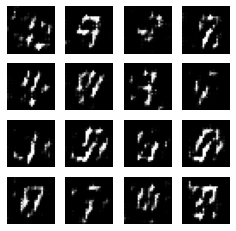

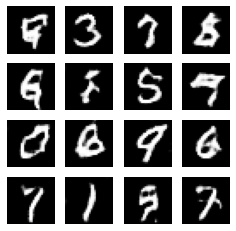

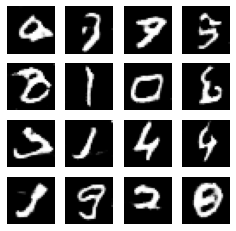

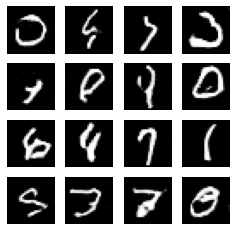

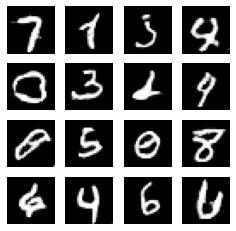

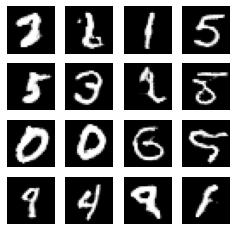

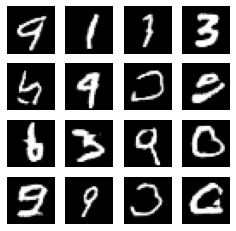

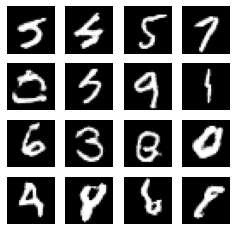

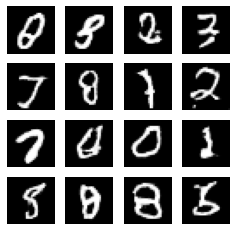

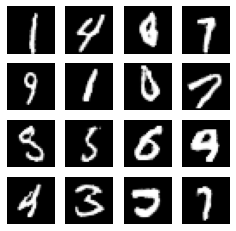

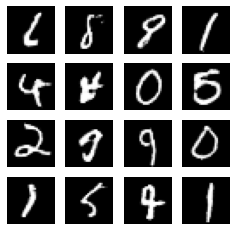

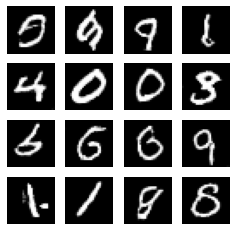

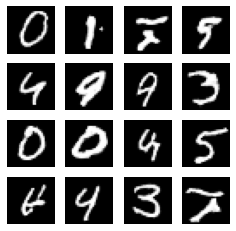

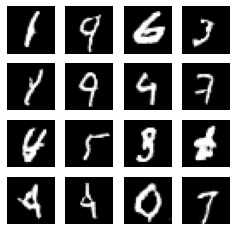

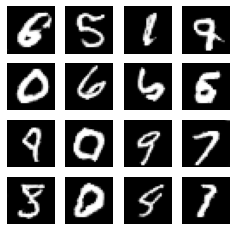

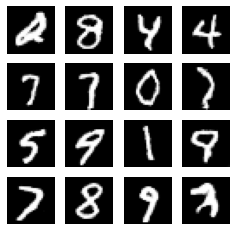

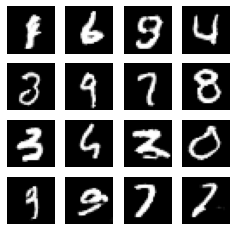

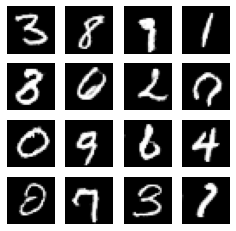

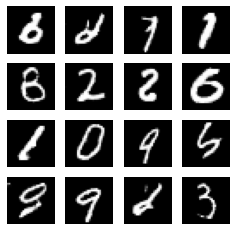

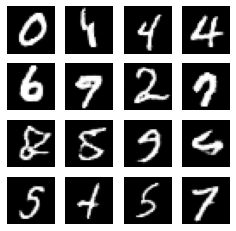

In [16]:
iterations = 20000
batch_size = 128
sample_interval = 1000

# Train the GAN for the specified number of iterations
train(iterations, batch_size, sample_interval)

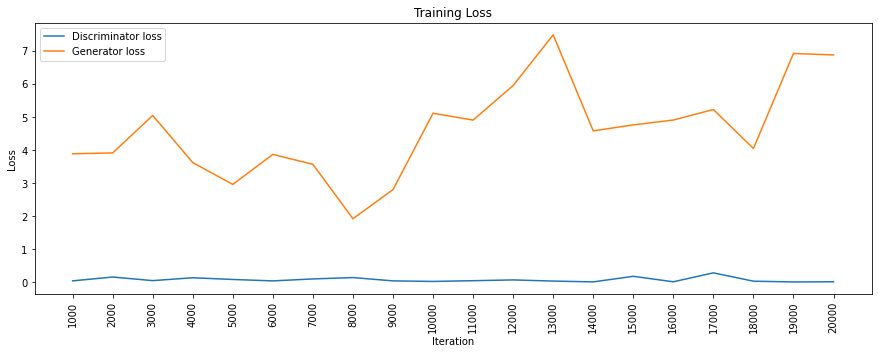

In [17]:
losses = np.array(losses)

# Plot training losses for Discriminator and Generator
plt.figure(figsize=(15, 5))
plt.plot(iteration_checkpoints, losses.T[0], label="Discriminator loss")
plt.plot(iteration_checkpoints, losses.T[1], label="Generator loss")

plt.xticks(iteration_checkpoints, rotation=90)

plt.title("Training Loss")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.legend()

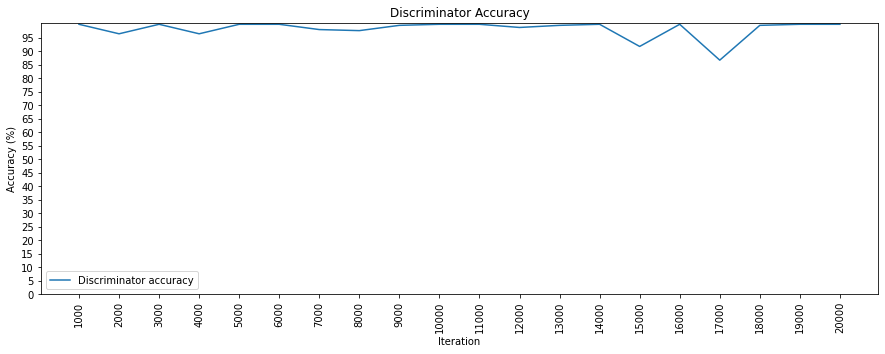

In [18]:
accuracies = np.array(accuracies)

# Plot Discriminator accuracy
plt.figure(figsize=(15, 5))
plt.plot(iteration_checkpoints, accuracies, label="Discriminator accuracy")

plt.xticks(iteration_checkpoints, rotation=90)
plt.yticks(range(0, 100, 5))

plt.title("Discriminator Accuracy")
plt.xlabel("Iteration")
plt.ylabel("Accuracy (%)")
plt.legend()